In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
mean = cards_to_age["age"].mean()
threshold = .005+(mean/1000)
shuffle_role = random.random()
print(f"{shuffle_role=}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.788429757641732; threshold=0.054854


In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(sum_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Power BI,29.550809,9.850270,15.287149,3
Network Terms,310.556809,20.703787,39.437026,15
Ubuntu,493.162300,18.967781,69.704840,26
GUI Docker Container,519.650513,24.745263,54.603148,21
SSH + SCP,756.769394,26.095496,102.593480,29
WinHex,774.577943,38.728897,138.573151,20
"Everything is Tuberculosis, Green",836.026688,36.348986,202.557302,23
Python + Oauth2.0,959.513036,79.959420,176.916311,12
CCH Tax Forms Project,970.984282,57.116722,135.763066,17
eDiscovery,1018.008636,18.852012,83.827059,54


# Histogram

sum of ages: ~38545.93


<Axes: >

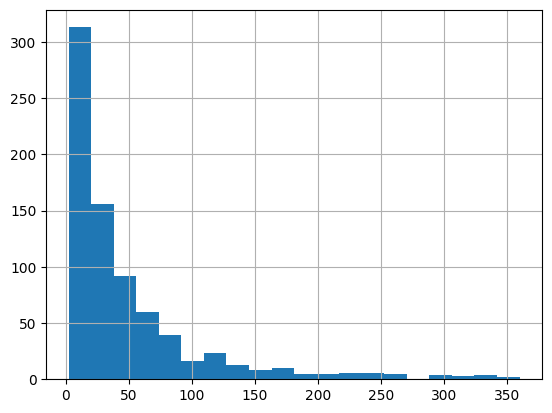

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~38545.93


<Axes: >

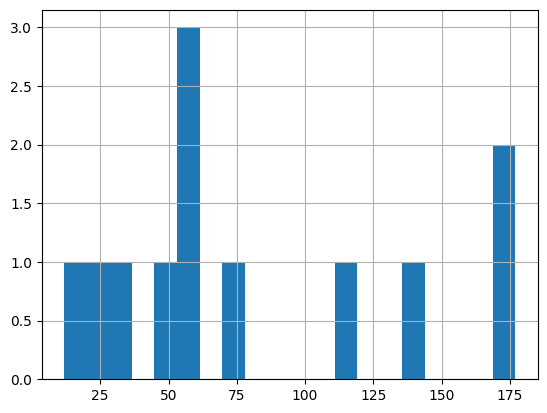

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python + Oauth2.0']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
n = random.choice([2, 3, 3, 4, 4, 5])

existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 770
Total card age: 38545.93


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
8,Django,Environment Variables (App Settings)\nStored i...,2128d44a5eb8fabbc02836ef410a2e0f,359.569593,87.473063,-359.569593,1399.569001,0.854501,16,0,0,-359.569593
9,Django,collectstatic\nCommand that gathers all static...,74139aee94cfc049c1a1c01582af7487,331.983349,87.473063,-359.569593,1399.569001,0.854501,16,1,0,-331.983349
10,Django,Collectstatic Step\nPart of Django deployment ...,52e99cf555a329f05921f2a497c12457,202.595873,87.473063,-359.569593,1399.569001,0.854501,16,2,0,-202.595873
108,Azure Files Documentation,Metadata caching is an enhancement for SSD Azu...,75e06c115adf39f142721e1ad795a557,349.822214,66.842126,-349.822214,2874.211418,0.352313,43,0,0,-349.822214
109,Azure Files Documentation,Ensure port 445 is open: The SMB protocol requ...,77e08c08f78b76a183210eb8b58b2b9e,253.892017,66.842126,-349.822214,2874.211418,0.352313,43,1,0,-253.892017
110,Azure Files Documentation,You can perform both item-level and share-leve...,57fb7bedb90f442a065e4b295b1fca97,229.763543,66.842126,-349.822214,2874.211418,0.352313,43,2,0,-229.763543
83,Active Directory and Azure Files,SRV Records\nDNS records used to locate servic...,f6d4521332358bf050d103389debc83d,341.194534,89.367883,-341.194534,2949.140154,0.790405,33,0,0,-341.194534
84,Active Directory and Azure Files,Kerberos Double-Hop\nA delegation problem wher...,e7196e7b196b58cc0b4b2b4a6a5e6949,323.157745,89.367883,-341.194534,2949.140154,0.790405,33,1,0,-323.157745
85,Active Directory and Azure Files,Kerberos Service Ticket\nA ticket issued by th...,abe21932a53e60679d96171f871e4106,267.337432,89.367883,-341.194534,2949.140154,0.790405,33,2,0,-267.337432
118,Python,Rotating File Handler\nlogging.handlers.Rotati...,e7c292c14924cb5ad6c123e2ed3b229a,335.041648,56.929415,-335.041648,3074.188429,0.185529,54,0,0,-335.041648


## Card Count

In [11]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(2994.3579475826946)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
8,Django,Environment Variables (App Settings)\nStored i...,2128d44a5eb8fabbc02836ef410a2e0f,359.569593,87.473063,-359.569593,1399.569001,0.854501,16,0,0,-359.569593
108,Azure Files Documentation,Metadata caching is an enhancement for SSD Azu...,75e06c115adf39f142721e1ad795a557,349.822214,66.842126,-349.822214,2874.211418,0.352313,43,0,0,-349.822214
83,Active Directory and Azure Files,SRV Records\nDNS records used to locate servic...,f6d4521332358bf050d103389debc83d,341.194534,89.367883,-341.194534,2949.140154,0.790405,33,0,0,-341.194534
118,Python,Rotating File Handler\nlogging.handlers.Rotati...,e7c292c14924cb5ad6c123e2ed3b229a,335.041648,56.929415,-335.041648,3074.188429,0.185529,54,0,0,-335.041648
9,Django,collectstatic\nCommand that gathers all static...,74139aee94cfc049c1a1c01582af7487,331.983349,87.473063,-359.569593,1399.569001,0.854501,16,1,0,-331.983349
58,Windows PATH Variable,System PATH vs User PATH\nSystem PATH: Applies...,fab7edcaf5619e41df5ee4f39429b039,328.643539,65.030167,-328.643539,1950.905008,0.836684,30,0,0,-328.643539
84,Active Directory and Azure Files,Kerberos Double-Hop\nA delegation problem wher...,e7196e7b196b58cc0b4b2b4a6a5e6949,323.157745,89.367883,-341.194534,2949.140154,0.790405,33,1,0,-323.157745
98,Microsoft Purview,You can apply just one sensitivity label to an...,50f85d7bb8f9e04601a53f72976eeb45,318.120643,74.715462,-318.120643,2839.187546,0.656040,38,0,0,-318.120643
63,Terraform Codebox,"In a Terraform module, names like ""main"" or ""t...",1b7ed79374e4be64070aa3e191990353,311.030595,54.524516,-311.030595,1635.735475,0.491691,30,0,0,-311.030595
99,Microsoft Purview,Data understanding is about ensure data has qu...,9a95bac80e7ba590c49d6bcab8edaf38,303.013678,74.715462,-318.120643,2839.187546,0.656040,38,1,0,-303.013678


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 50.060'